In [18]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [7, 7]

# Exporting predictive models

Let's remember the last step on the data science process.

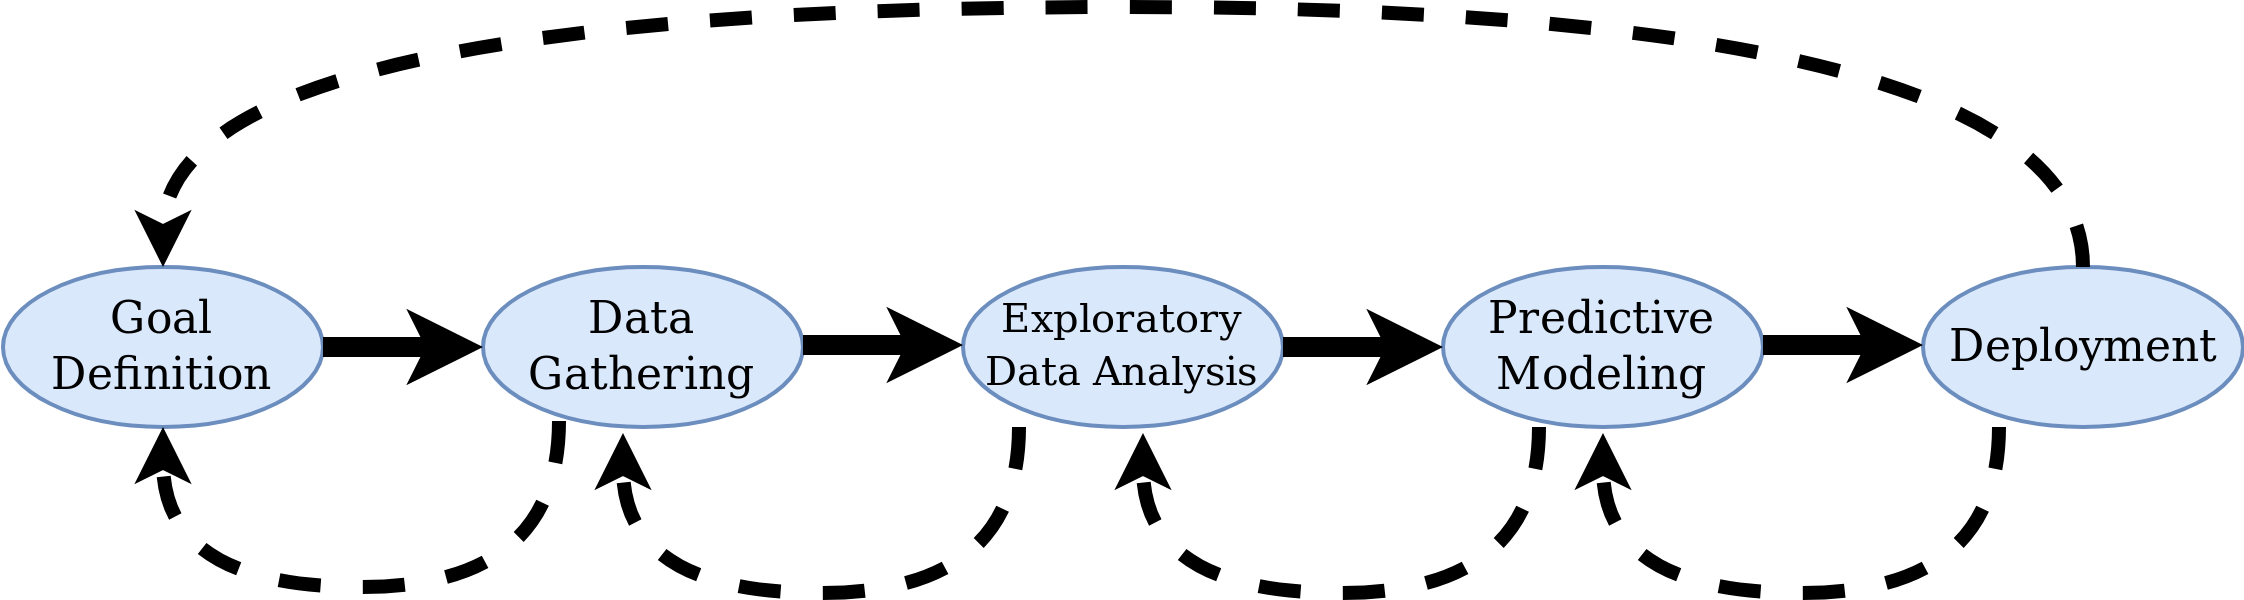

In [19]:
Image("data science process.png")

Now we are at the last step of the process, and we are going to see how to export the models that we trained.

So far we have seen how to train predictive models on a jupyter notebook. This is fine when the goal of a project is to export the predictions and save them somewhere (a csv file, or a database).  We can just run our notebook whenever we want to update the predictions.

However, sometimes we have to build a **predictive application**, that is, we have to save the models to be used somewhere else. One importance difference between a Data Scientist and a researcher or an analyst is that a Data Scientist is expected to create models that can be used in a production environment.

Here we are going to see how we can export trained predictive models so they can be used on a predictive application.



### Predictive Application. Real State Desktop App

To do so, we are going to assume the role of a Data Scientist at a real state company. Our primary goal is to build a predictive application that we can install in our company's real state agents to help them decide the price of new listings.

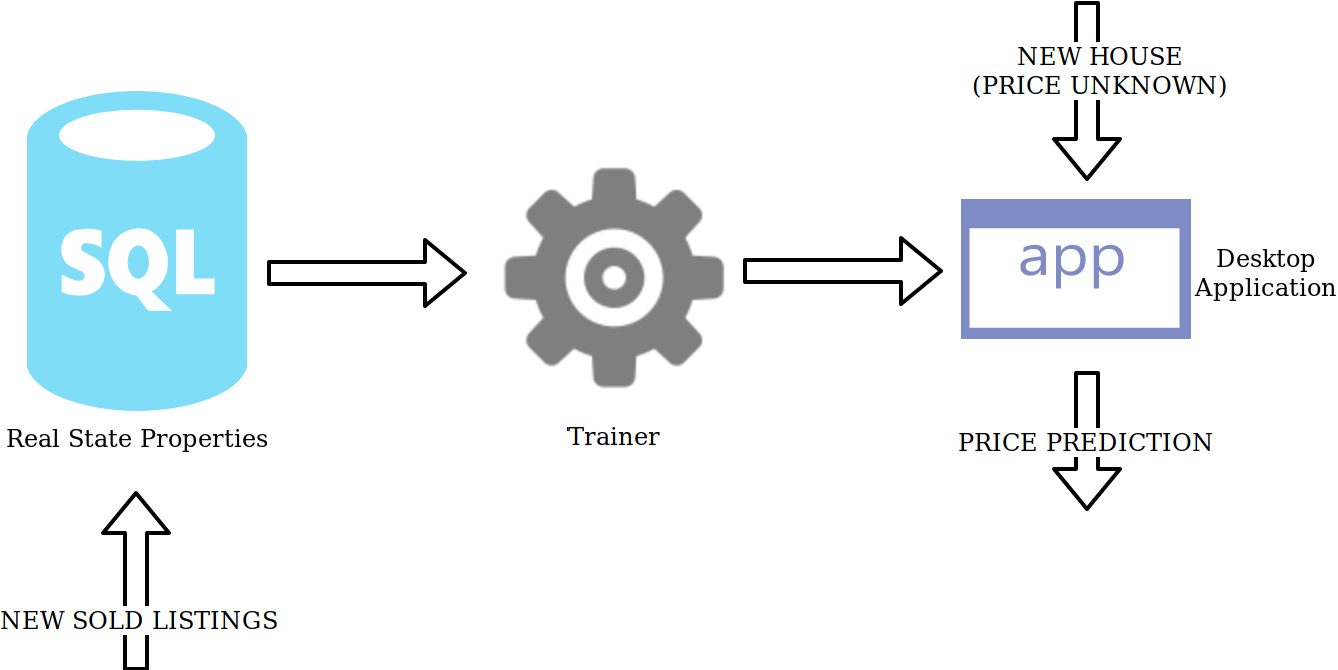

In [20]:
Image("real_state_desktopp_app.png")

We will use the [Gooey](https://github.com/chriskiehl/Gooey) library to create a simple Graphical User Interface (GUI) from our script.

### Loading data

Our real state company has a database where every single house is stored, including information about the house as well as the sale price. This will be our main dataset to create predictive models.

In [21]:
import sqlite3

conn = sqlite3.connect("listings.db")
listings = pd.read_sql("select * from listings", conn)

In [40]:
from sklearn.model_selection import train_test_split
del listings["index"]
train, test = train_test_split(listings, test_size=0.1)
train.to_csv("cli_app/listings_with_price.csv", index=False)
test.drop(columns="sale_price").to_csv("cli_app/input_listings.csv", index=False)

In [22]:
listings.head()

,index,building_class,lot_area,overall_quality,overall_condition,year_build,first_floor_area,second_floor_area,n_bedrooms,n_kitchens,n_full_baths,n_half_baths,pool_area,garage_area,n_fireplaces,sale_price,house_style,foundation
0,0,60,8450,7,5,2003,856,854,3,1,2,1,0,548,0,208500,2Story,PConc
1,1,20,9600,6,8,1976,1262,0,3,1,2,0,0,460,1,181500,1Story,CBlock
2,2,60,11250,7,5,2001,920,866,3,1,2,1,0,608,1,223500,2Story,PConc
3,3,70,9550,7,5,1915,961,756,3,1,1,0,0,642,1,140000,2Story,BrkTil
4,4,60,14260,8,5,2000,1145,1053,4,1,2,1,0,836,1,250000,2Story,PConc


In [23]:
listings.shape

(1460, 18)

In [24]:
listings.head()

,index,building_class,lot_area,overall_quality,overall_condition,year_build,first_floor_area,second_floor_area,n_bedrooms,n_kitchens,n_full_baths,n_half_baths,pool_area,garage_area,n_fireplaces,sale_price,house_style,foundation
0,0,60,8450,7,5,2003,856,854,3,1,2,1,0,548,0,208500,2Story,PConc
1,1,20,9600,6,8,1976,1262,0,3,1,2,0,0,460,1,181500,1Story,CBlock
2,2,60,11250,7,5,2001,920,866,3,1,2,1,0,608,1,223500,2Story,PConc
3,3,70,9550,7,5,1915,961,756,3,1,1,0,0,642,1,140000,2Story,BrkTil
4,4,60,14260,8,5,2000,1145,1053,4,1,2,1,0,836,1,250000,2Story,PConc


In [25]:
target_variable = "sale_price"
independent_variables = listings.drop(columns=[target_variable, "index"]).columns

In [26]:
numerical_cols = listings[independent_variables].select_dtypes(np.number).columns
categorical_cols = listings[independent_variables].select_dtypes(object).columns

We are going to create a pipeline to train the model, then we will import it

In [27]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from category_encoders import OneHotEncoder

from mlxtend.feature_selection import ColumnSelector

we are going to use`category_encoders.OneHotEncoder` . because it has the parameter `handle_unknown="impute"`, that can deal with unknown categorical variables.

In [28]:
processing_pipeline = make_union(
    Pipeline([
        ("categorical_columns", ColumnSelector(cols=categorical_cols)),
        ("categorical_encoder", OneHotEncoder())
    ]),
    Pipeline([
        ("numerical_columns", ColumnSelector(cols=numerical_cols)),
        ("numerical_imputer", SimpleImputer()),
        ("numerical_scaler", StandardScaler())
    ])
)

In [29]:
processing_pipeline.fit_transform(listings)

array([[ 1.        ,  0.        ,  0.        , ..., -0.06869175,
         0.35100032, -0.95122649],
       [ 0.        ,  1.        ,  0.        , ..., -0.06869175,
        -0.06073101,  0.60049493],
       [ 1.        ,  0.        ,  0.        , ..., -0.06869175,
         0.63172623,  0.60049493],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.06869175,
        -1.03391416,  2.15221636],
       [ 0.        ,  1.        ,  0.        , ..., -0.06869175,
        -1.09005935, -0.95122649],
       [ 0.        ,  1.        ,  0.        , ..., -0.06869175,
        -0.9216238 , -0.95122649]])

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA, TruncatedSVD

In [31]:
predictive_pipeline = Pipeline([
    ("processing", processing_pipeline),
    ("estimator", RandomForestRegressor())
])

In [32]:
predictive_pipeline.fit(X=listings[independent_variables], 
                        y=listings[target_variable])

Pipeline(memory=None,
     steps=[('processing', FeatureUnion(n_jobs=None,
       transformer_list=[('pipeline-1', Pipeline(memory=None,
     steps=[('categorical_columns', ColumnSelector(cols=Index(['house_style', 'foundation'], dtype='object'),
        drop_axis=False)), ('categorical_encoder', OneHotEncoder(cols=[0, 1], dr...ators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [33]:
predictive_pipeline.predict(X=listings.head())

array([197950., 181800., 219490., 150990., 271950.])

we can use  `get_params` to find the parameter names for the pipeline.

In [34]:
predictive_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'processing', 'estimator', 'processing__n_jobs', 'processing__transformer_list', 'processing__transformer_weights', 'processing__pipeline-1', 'processing__pipeline-2', 'processing__pipeline-1__memory', 'processing__pipeline-1__steps', 'processing__pipeline-1__categorical_columns', 'processing__pipeline-1__categorical_encoder', 'processing__pipeline-1__categorical_columns__cols', 'processing__pipeline-1__categorical_columns__drop_axis', 'processing__pipeline-1__categorical_encoder__cols', 'processing__pipeline-1__categorical_encoder__drop_invariant', 'processing__pipeline-1__categorical_encoder__handle_unknown', 'processing__pipeline-1__categorical_encoder__impute_missing', 'processing__pipeline-1__categorical_encoder__return_df', 'processing__pipeline-1__categorical_encoder__use_cat_names', 'processing__pipeline-1__categorical_encoder__verbose', 'processing__pipeline-2__memory', 'processing__pipeline-2__steps', 'processing__pipeline-2__numerical_columns', 

Now we can do a search to find the optimal parameters

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist_random = {
    "estimator__max_depth": [3, None],
    "estimator__max_features": sp_randint(1, 11),
    "estimator__min_samples_split": sp_randint(2, 11),
    "estimator__min_samples_leaf": sp_randint(1, 11),
    "estimator__bootstrap": [True, False],
    "estimator__n_estimators": np.linspace(10,1000,10).astype(int),
    "estimator__min_impurity_decrease": np.logspace(-1, 0.0),
    "processing__pipeline-2__numerical_scaler": [StandardScaler(), MinMaxScaler(), RobustScaler()],
}

random_search = RandomizedSearchCV(
    estimator=predictive_pipeline, 
    param_distributions=param_dist_random, cv=3, refit=True,
    scoring="neg_mean_squared_error", 
    return_train_score=True,
    n_iter=5, n_jobs=-1)

In [36]:
random_search.fit(X=listings[independent_variables],
                    y=listings[target_variable])

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('processing', FeatureUnion(n_jobs=None,
       transformer_list=[('pipeline-1', Pipeline(memory=None,
     steps=[('categorical_columns', ColumnSelector(cols=Index(['house_style', 'foundation'], dtype='object'),
        drop_axis=False)), ('categorical_encoder', OneHotEncoder(cols=[0, 1], dr...ators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'estimator__max_depth': [3, None], 'estimator__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff25d7870b8>, 'estimator__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff25d7871d0>, 'estimator__min_samples_leaf': <scipy.sta...obustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)]},
          pre_

In [37]:
random_search.predict(listings.head())

array([202683.55828903, 173271.34155143, 222781.31348454, 160466.79615545,
       293960.01663142])

In [38]:
random_search.best_estimator_.steps

[('processing', FeatureUnion(n_jobs=None,
         transformer_list=[('pipeline-1', Pipeline(memory=None,
       steps=[('categorical_columns', ColumnSelector(cols=Index(['house_style', 'foundation'], dtype='object'),
          drop_axis=False)), ('categorical_encoder', OneHotEncoder(cols=[0, 1], drop_invariant=False, handle_unknown='impute',
         imp...     verbose=0)), ('numerical_scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]))],
         transformer_weights=None)),
 ('estimator',
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features=10, max_leaf_nodes=None,
             min_impurity_decrease=0.9102981779915218,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=7, min_weight_fraction_leaf=0.0,
             n_estimators=890, n_jobs=None, oob_score=False,
             random_state=None, verbose=0, warm_start=False))]

In [39]:
random_search.best_params_

{'estimator__bootstrap': True,
 'estimator__max_depth': None,
 'estimator__max_features': 10,
 'estimator__min_impurity_decrease': 0.9102981779915218,
 'estimator__min_samples_leaf': 5,
 'estimator__min_samples_split': 7,
 'estimator__n_estimators': 890,
 'processing__pipeline-2__numerical_scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

And we can evaluate the mean squared error.

In [22]:
np.min(np.sqrt(np.abs(random_search.cv_results_['mean_test_score'])))

31041.698145520164

Now we have a trained pipeline, let's see how we can export it.

### Option 1. Pipeline export with joblib

We have to export 2 things to recreate the pipeline:

**1. The trained pipeline.**

We can use `joblib` to save our pipeline to disk. Joblib is a pickle based library designed for scikit-learn.

**NOTE** Joblib doesn't export the custom transformer we created. This means we will have to define ColumnTransformer when we load the pipeline.

In [23]:
from sklearn.externals import joblib

In [24]:
joblib.dump(random_search, './desktop_app/pipeline.pkl') 

['./desktop_app/pipeline.pkl']

This way we can reload the pretrained pipeline and directly predict.

In [25]:
reloaded_pipeline = joblib.load('./desktop_app/pipeline.pkl')

In [26]:
reloaded_pipeline.predict(listings.head())

array([207327.73504273, 183040.27008547, 224744.27295482, 144872.08910256,
       261975.69871795])

**2. The datatypes for each column**

We need to know the column names that the pipeline takes to validate the input. When we receive a new prediction on our application, we wont have access to the training dataset, so we need a list that we can check to make sure the new observation columns will work with the model.

Also, the dtypes for each variable need to match at prediction time with the types we used to train the model.

In [27]:
listings.head()

,index,building_class,lot_area,overall_quality,overall_condition,year_build,first_floor_area,second_floor_area,n_bedrooms,n_kitchens,n_full_baths,n_half_baths,pool_area,garage_area,n_fireplaces,sale_price,house_style,foundation
0,0,60,8450,7,5,2003,856,854,3,1,2,1,0,548,0,208500,2Story,PConc
1,1,20,9600,6,8,1976,1262,0,3,1,2,0,0,460,1,181500,1Story,CBlock
2,2,60,11250,7,5,2001,920,866,3,1,2,1,0,608,1,223500,2Story,PConc
3,3,70,9550,7,5,1915,961,756,3,1,1,0,0,642,1,140000,2Story,BrkTil
4,4,60,14260,8,5,2000,1145,1053,4,1,2,1,0,836,1,250000,2Story,PConc


In [28]:
listings.dtypes

index                 int64
building_class        int64
lot_area              int64
overall_quality       int64
overall_condition     int64
year_build            int64
first_floor_area      int64
second_floor_area     int64
n_bedrooms            int64
n_kitchens            int64
n_full_baths          int64
n_half_baths          int64
pool_area             int64
garage_area           int64
n_fireplaces          int64
sale_price            int64
house_style          object
foundation           object
dtype: object

In [29]:
dtypes_dict = {}
for col in listings[independent_variables].columns:
    dtypes_dict[col] = {"dtype": listings[col].dtype}
    if listings[col].dtype == object:
        dtypes_dict[col]["options"] = listings[col].unique().tolist()

In [30]:
dtypes_dict

{'building_class': {'dtype': dtype('int64')},
 'lot_area': {'dtype': dtype('int64')},
 'overall_quality': {'dtype': dtype('int64')},
 'overall_condition': {'dtype': dtype('int64')},
 'year_build': {'dtype': dtype('int64')},
 'first_floor_area': {'dtype': dtype('int64')},
 'second_floor_area': {'dtype': dtype('int64')},
 'n_bedrooms': {'dtype': dtype('int64')},
 'n_kitchens': {'dtype': dtype('int64')},
 'n_full_baths': {'dtype': dtype('int64')},
 'n_half_baths': {'dtype': dtype('int64')},
 'pool_area': {'dtype': dtype('int64')},
 'garage_area': {'dtype': dtype('int64')},
 'n_fireplaces': {'dtype': dtype('int64')},
 'house_style': {'dtype': dtype('O'),
  'options': ['2Story',
   '1Story',
   '1.5Fin',
   '1.5Unf',
   'SFoyer',
   'SLvl',
   '2.5Unf',
   '2.5Fin']},
 'foundation': {'dtype': dtype('O'),
  'options': ['PConc', 'CBlock', 'BrkTil', 'Wood', 'Slab', 'Stone']}}

In [31]:
joblib.dump(dtypes_dict, './desktop_app/dtypes.pkl')

['./desktop_app/dtypes.pkl']

Now we can create a new method that takes a new observation as a dictionary and predicts.

In [32]:
new_observation = listings.to_dict(orient="records")[0]
new_observation

{'index': 0,
 'building_class': 60,
 'lot_area': 8450,
 'overall_quality': 7,
 'overall_condition': 5,
 'year_build': 2003,
 'first_floor_area': 856,
 'second_floor_area': 854,
 'n_bedrooms': 3,
 'n_kitchens': 1,
 'n_full_baths': 2,
 'n_half_baths': 1,
 'pool_area': 0,
 'garage_area': 548,
 'n_fireplaces': 0,
 'sale_price': 208500,
 'house_style': '2Story',
 'foundation': 'PConc'}

In [33]:
def dict_to_df(obs, dtypes):
    obs_df = pd.DataFrame([obs])
    for col, data in dtypes.items():
        if col in obs_df.columns:
            obs_df[col] = obs_df[col].astype(data["dtype"])
        else:
            obs_df[col] = None 
    return obs_df

obs_df = dict_to_df(new_observation, dtypes_dict)
obs_df

,building_class,first_floor_area,foundation,garage_area,house_style,index,lot_area,n_bedrooms,n_fireplaces,n_full_baths,n_half_baths,n_kitchens,overall_condition,overall_quality,pool_area,sale_price,second_floor_area,year_build
0,60,856,PConc,548,2Story,0,8450,3,0,2,1,1,5,7,0,208500,854,2003


Now we can predict with the pipeline

In [35]:
reloaded_pipeline.predict(obs_df)

array([207327.73504273])

Now we would just need a web application that can load a model and takes prediction requests

### Option 2. Manually evaluate the output of the model

This is by far the hardest option, but sometimes it has to be done if the performance is a big issue (think real time sensors) or if the software is a constraint (for example , adding a predictive functionality to a legacy system.

Basically, if we know how the model works, we can code a function to evaluate it. A linear regression output is just a dot product, a decission tree is a group of if-else statements. 

This approach should be only used as a last resort.


### BONUS - Option 3. Export to PMML

PMML **(Predictive Modelling Markup Language)** is a format that tries to be a standard for predictive modeling that is platform agnostic, so you can train the models with a framework and then read the trained models on another platform.

To export scikit-learn to pmml there is a package [sklearn2pmml](https://github.com/jpmml/sklearn2pmml) that allows us to export pipelines to pmml

However, pmml is only compatible with a subset of all the options available in scikit-learn, so this means we cant really use it with our custom transformers.

We will run here the example found on `sklearn2pmml` documentation, to export a pipeline trained on the Iris dataset to pmml.

In [51]:
from sklearn.datasets import load_iris
import pandas as pd

In [52]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=['Sepal.Length', 'Sepal.Width', 
                                           'Petal.Length','Petal.Width'])
iris_df["Species"] = iris.target

In [53]:
iris_df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [41]:
from sklearn2pmml import PMMLPipeline
from sklearn2pmml.decoration import ContinuousDomain
from sklearn_pandas import DataFrameMapper
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_iris


iris_pipeline = PMMLPipeline([
    ("mapper", DataFrameMapper([
    (["Sepal.Length", "Sepal.Width", "Petal.Length", "Petal.Width"], [ContinuousDomain(), Imputer()])
    ])),
    ("pca", PCA(n_components = 3)),
    ("selector", SelectKBest(k = 2)),
    ("classifier", LogisticRegression())
])
iris_pipeline.fit(iris_df, iris_df["Species"])

from sklearn2pmml import sklearn2pmml

sklearn2pmml(iris_pipeline, "LogisticRegressionIris.pmml", with_repr = True)

The format pmml is an xml file where the pipeline is described.

In [42]:
with open("LogisticRegressionIris.pmml") as fname:
    pmml = fname.read()
print(pmml)

<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<PMML xmlns="http://www.dmg.org/PMML-4_3" xmlns:data="http://jpmml.org/jpmml-model/InlineTable" version="4.3">
	<Header>
		<Application name="JPMML-SkLearn" version="1.5.4"/>
		<Timestamp>2018-07-17T12:28:40Z</Timestamp>
	</Header>
	<MiningBuildTask>
		<Extension>PMMLPipeline(steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[(['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width'], [ContinuousDomain(high_value=None, invalid_value_replacement=None,
         invalid_value_treatment='return_invalid', low_value=None,
         missing_value_replacement=None, missing_value_treatment='as_is',
         missing_values=None, outlier_treatment='as_is', with_data=True,
         with_statistics=True), Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)])],
        input_df=False, sparse=False)),
       ('pca', PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,

Once we have the pmml we can import it to any framework that supports pmml, for example [Openscoring](https://github.com/openscoring/openscoring)

### 4. Platform specific serving frameworks.

Some ML platforms have specific solutions for serving trained models. Please note that all of these are in early stages of development.

- For tensorflow models, you can use [tflite](https://www.tensorflow.org/mobile/tflite/)
- For Keras models, you can use [poket-tensor](https://github.com/GValiente/pocket-tensor)
- For scikit-learn, spark or Tensorflow, you can use [mleap](http://mleap-docs.combust.ml/)

# Packaging

Packaging an application is the process of turning a python app (with its multiple .py scripts) into a single executable that is platform specific (so a .exe file for windows, a dmg file for Mac OS X).

There are different tools that allow us to package python apps. Each one has its pros and cons. Here are a few of the most popular ones.

- [pyinstaller](https://realpython.com/pyinstaller-python/)
- [py2exe](http://www.py2exe.org/index.cgi/Tutorial)
- [cx_freeze](https://pythonprogramming.net/converting-python-scripts-exe-executables/)
